# Tuning rasters for single neurons

By Charles Xu @ DJA Lab, Caltech

## Set up environment

### Import packages

In [2]:
# Import packages
# numpy
import numpy as np

# scipy
import scipy.io as sio
from scipy.io import loadmat
from scipy.io import savemat

# sklearn
import sklearn
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

# System
import sys

# Custom packages
# if '/Users/alveus/Documents/WorkingDirectory/Packages/Python' not in sys.path:
#     sys.path.insert(0, '/Users/alveus/Documents/WorkingDirectory/Packages/Python')
# import colormaps as cmaps # custom colormaps (see: https://gist.github.com/justiceamoh/0aca7df49c35fc0a38d2)


### Helper functions

In [18]:
# Tuning analysis functions
# Define function to perform k-means with silhouette analysis
def plot_kmeans_silhouette(range_n_clusters, data):
    """
    range_n_clusters: ndarray of size (n_clusters,)
        An array of the number of clusters to try
    data: ndarray of size (n_samples, n_features)
        Data to perform k-means clustering and silhouette analysis on
    """
    n_samples = data.shape[0]
    num_clusters = len(range_n_clusters)
    silhouette_scores = []
    fig, axs = plt.subplots(nrows=num_clusters, ncols=2, figsize=(10, 4*num_clusters), constrained_layout=True)
    for i in range(num_clusters):
        n_clusters = range_n_clusters[i]
        axs[i, 0].set_xlim([-0.1, 1])
        axs[i, 0].set_ylim([0, n_samples + (n_clusters + 1) * 10])

        # Fit the KMeans model and calculate silhouette scores
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        cluster_labels = kmeans.labels_
        silhouette_score_value = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_score_value)
        silhouette_scores.append(silhouette_score_value)
        silhouetee_samples = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for n in range(n_clusters):
            nth_cluster_silhouette_values = silhouetee_samples[cluster_labels == n] # Aggregate the silhouette scores for samples belonging to cluster n
            nth_cluster_silhouette_values.sort() # Sort the silhouette scores

            nth_cluster_size = nth_cluster_silhouette_values.shape[0] # Get the size of cluster n
            y_upper = y_lower + nth_cluster_size # Set the position of the silhouette plot for cluster n
            color = cm.nipy_spectral(float(n) / n_clusters)
            axs[i, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, nth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[i, 0].text(-0.05, y_lower + 0.5 * nth_cluster_size, str(n)) # Label the silhouette plots with their cluster numbers at the middle

            y_lower = y_upper + 10

        axs[i, 0].set_title("Silhouette plot for the various clusters (n_clusters = %d)" % n_clusters)
        axs[i, 0].set_xlabel("Silhouette coefficient values")
        axs[i, 0].set_ylabel("Cluster label")

        axs[i, 0].axvline(x=silhouette_score_value, color="red", linestyle="--")
        axs[i, 0].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the cluster
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        if data.shape[1] == 2:
            axs[i, 1].scatter(data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = kmeans.cluster_centers_
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("Visualization of the clustered data (n_clusters = %d)" % n_clusters)
            axs[i, 1].set_xlabel("1st feature in feature space")
            axs[i, 1].set_ylabel("2nd feature in feature space")

        else:
            pca = PCA(n_components=2).fit(data)
            data_pca = pca.transform(data)
            axs[i, 1].scatter(data_pca[:, 0], data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = pca.transform(kmeans.cluster_centers_)
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("The visualization of the clustered data.")
            axs[i, 1].set_xlabel("PC1 in PCA mapping of feature space")
            axs[i, 1].set_ylabel("PC2 in PCA mapping of feature space")

        plt.suptitle(
            "k-means clustering with Sillhouette analysis",
            fontsize=14,
            fontweight="bold",
        )

    print("The number of clusters that maximizes silhouette score is: ", range_n_clusters[np.argmax(silhouette_scores)])
    return fig, axs, range_n_clusters[np.argmax(silhouette_scores)]

# Define function to cluster neurons
def fit_kmeans(n_clusters, data, neuron_ids=None):
    """
    n_clusters: int
        Number of clusters to group neurons into
    data: ndarray of size (n_samples, n_features)
        Data to cluster
    neuron_ids: nddarray of size (n_neurons, )
        Neuron IDs
    """
    # Fit k-means clustering with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    cluster_labels = kmeans.labels_

    # Group neurons by cluster
    data_reordered = np.zeros_like(data)
    neuron_ids_reordered = np.zeros_like(cluster_labels)
    n_ith_cluster_lower = 0
    n_ith_cluster_upper = 0
    for i in range(n_clusters):
        n_ith_cluster_upper = n_ith_cluster_lower + sum(cluster_labels == i)
        print(sum(cluster_labels == i))
        data_reordered[n_ith_cluster_lower:n_ith_cluster_upper, :] = data[cluster_labels == i, :]
        if neuron_ids is None:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = np.where(cluster_labels == i)[0] + 1
        else:
            neuron_ids_reordered[n_ith_cluster_lower:n_ith_cluster_upper] = neuron_ids[np.where(cluster_labels == i)] + 1
        n_ith_cluster_lower = n_ith_cluster_upper

    return cluster_labels, data_reordered, neuron_ids_reordered

### Load data

Preprocessing is done with MATLAB using preprocessHangryMice.m. The script performs these actions:
1. Manually define behavioral label alignment and grouping.
2. Fill in behavioral data for missing labels with zeros.
3. Combine/merge stimuli labels and data.
4. Smooth neural data.
5. Save preprocessed data to .mat file.

The preprocessed data consists of the following necessary variables:
- neuralDataPreprocessed: array of size (n_neurons, n_samples). Smoothed neural data
- behaviorDataPreprocessed: array of size (n_behaviors, n_samples). Behavior data
- behaviorLabelsPreprocessed: cell array of size (n_behaviors, ). Behavior labels
- stimuliDataPreprocessed: array of size (n_stimuli, n_samples). Stimuli data
- stimuliLabelsPreprocessed: cell array of size (n_stimuli, ). Stimuli labels
- (optional) neuralData: array of size (n_neurons, n_samples). Raw neural data
Note: If compare across both conditions, make sure the labels from the two datasets match. Fill in the missing data with all zeros

In [4]:
# User inputs
datafile_M1 = r'data/EG1-1_fasted_unreg_preprocessed_use.mat'
datafile_M2 = r'data/EG1-4_fasted_unreg_preprocessed_use.mat'

In [5]:
mat_M1 = sio.loadmat(datafile_M1)
mat_M2 = sio.loadmat(datafile_M2)

input_raw_M1 = mat_M1['behaviorDataPreprocessed'] # Behavior data
input_raw_M2 = mat_M2['behaviorDataPreprocessed']

output_raw_M1 = np.array(mat_M1['neuralDataPreprocessed']) # Neural data
output_raw_M2 = np.array(mat_M2['neuralDataPreprocessed'])

labels_raw_M1 = mat_M1['behaviorLabelsPreprocessed'] # Behavior labels
labels_M1 = [] # Behavior labels
for i in range(len(labels_raw_M1)):
    labels_M1.append(labels_raw_M1[i][0][0])

labels_raw_M2 = mat_M2['behaviorLabelsPreprocessed']
labels_M2 = [] # Behavior labels
for i in range(len(labels_raw_M2)):
    labels_M2.append(labels_raw_M2[i][0][0])

if all(labels_raw_M1 == labels_raw_M2):
    labels = labels_M1
else:
    sys.exit('Stimuli labels do not match!')

stimuli_M1 = mat_M1['stimuliDataPreprocessed'] # Stimuli
stimuli_labels_M1_raw = mat_M1['stimuliLabelsPreprocessed'] # Stimuli labels
stimuli_labels_M1 = []
for i in range(len(stimuli_labels_M1_raw)):
    stimuli_labels_M1.append(stimuli_labels_M1_raw[i][0][0])

stimuli_M2 = mat_M2['stimuliDataPreprocessed'] # Stimuli
stimuli_labels_M2_raw = mat_M2['stimuliLabelsPreprocessed'] # Stimuli labels
stimuli_labels_M2 = []
for i in range(len(stimuli_labels_M2_raw)):
    stimuli_labels_M2.append(stimuli_labels_M2_raw[i][0][0])

print(f'Number of input variables (M1): {input_raw_M1.shape[0]}')
print(f'Length of session (M1): {input_raw_M1.shape[1]}')
print(f'Number of input variables (M2): {input_raw_M2.shape[0]}')
print(f'Length of session (M2): {input_raw_M2.shape[1]}')
print(f'The input variables are: {labels}')
print(f'Number of output variables (M1): {output_raw_M1.shape[0]}')
print(f'Number of output variables (M2): {output_raw_M2.shape[0]}')
print(f'Number of stimuli variables (M1): {stimuli_M1.shape[0]}')
print(f'The stimuli variables (M1) are: {stimuli_labels_M1}')
print(f'Number of stimuli variables (M2): {stimuli_M2.shape[0]}')
print(f'The stimuli variables (M2) are: {stimuli_labels_M2}')

Number of input variables (M1): 8
Length of session (M1): 6392
Number of input variables (M2): 8
Length of session (M2): 14759
The input variables are: ['baseline', 'introduction', 'sniffM', 'attack', 'food_approach', 'food_sniff', 'eating', 'drinking']
Number of output variables (M1): 144
Number of output variables (M2): 116
Number of stimuli variables (M1): 3
The stimuli variables (M1) are: ['baseline', 'male', 'food']
Number of stimuli variables (M2): 5
The stimuli variables (M2) are: ['baseline', 'male', 'object', 'food', 'male2']


## Process data

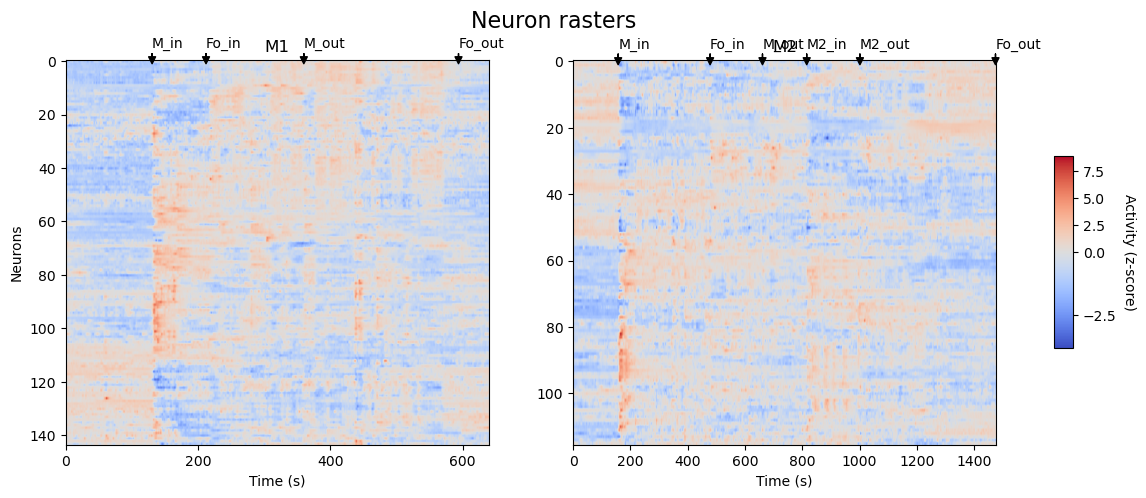

In [6]:
# Plot raw neuron rasters
time_M1 = output_raw_M1.shape[1]
time_M2 = output_raw_M2.shape[1]

# fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 5), gridspec_kw={'height_ratios': [1, 5]})
# fig.subplots_adjust(hspace=0, wspace=0.1)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Determine the color scale based on the min and max of both datasets
vmin = min(output_raw_M1.min(), output_raw_M2.min())
vmax = max(output_raw_M1.max(), output_raw_M2.max())

# Add colored bars for the stimuli in the M1 condition
# bar_colors = ['white', 'tab:blue', 'tab:red', 'tab:orange']
# cmap_bar = ListedColormap(bar_colors)

# stimulishow_M1 = np.zeros_like(stimuli_M1)
# for i in range(len(stimuli_labels_M1)):
#     stimulishow_M1[i, :] = stimuli_M1[i, :] * (i+1)
# axs[0, 0].imshow(stimulishow_M1, aspect="auto", cmap=cmap_bar, interpolation='none')
# axs[0, 0].spines['top'].set_visible(False)
# axs[0, 0].spines['left'].set_visible(False)
# axs[0, 0].spines['right'].set_visible(False)
# axs[0, 0].set_xticks([])
# axs[0, 0].set_yticks([])
# axs[0, 0].set_title('M1')

# Add colored bars for the stimuli in the M2 condition
# bar_colors = ['white', 'tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
# cmap_bar = ListedColormap(bar_colors)

# stimulishow_M2 = np.zeros_like(stimuli_M2)
# for i in range(len(stimuli_labels_M2)):
#     stimulishow_M2[i, :] = stimuli_M2[i, :] * (i+1)
# axs[0, 1].imshow(stimulishow_M2, aspect="auto", cmap=cmap_bar, interpolation='none')
# axs[0, 1].spines['top'].set_visible(False)
# axs[0, 1].spines['left'].set_visible(False)
# axs[0, 1].spines['right'].set_visible(False)
# axs[0, 1].set_xticks([])
# axs[0, 1].set_yticks([])
# axs[0, 1].set_title('M2')

# Create a list of Patch objects for the legend
# patches = [mpatches.Patch(color=bar_colors[i+1], label=stimuli_label) for i, stimuli_label in enumerate(stimuli_labels_M2)] # Use M2 because it has more stimuli
# axs[0, 1].legend(handles=patches, bbox_to_anchor=(1.05, 1.5), loc='upper left', borderaxespad=0.)

# Create a diverging color map normalized around 0
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the neuron raster for the M1 condition
im0 = axs[0].imshow(output_raw_M1, cmap='coolwarm', aspect='auto', norm=divnorm)
axs[0].set_xticks(np.arange(time_M1, step=2000))
axs[0].set_xticklabels(np.arange(time_M1, step=2000)//10)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Neurons')
axs[0].set_title('M1')

# Plot the neuron raster for the M2 condition
im1 = axs[1].imshow(output_raw_M2, cmap='coolwarm', aspect='auto', norm=divnorm)
axs[1].set_xticks(np.arange(time_M2, step=2000))
axs[1].set_xticklabels(np.arange(time_M2, step=2000)//10)
axs[1].set_xlabel('Time (s)')
axs[1].set_title('M2')

# Add stimuli annotations
stim_time_M1 = []
stim_annot_M1 = ['M_in', 'M_out', 'Fo_in', 'Fo_out']
for i, stim in enumerate(stimuli_labels_M1):
    if stim == 'male':
        male = stimuli_M1[i]
        indices = np.argwhere(male)
        stim_time_M1.append(indices[0][0])
        stim_time_M1.append(indices[-1][0])
    if stim == 'food':
        food = stimuli_M1[i]
        indices = np.argwhere(food)
        stim_time_M1.append(indices[0][0])
        stim_time_M1.append(indices[-1][0])

stim_time_M2 = []
stim_annot_M2 = ['M_in', 'M_out', 'Fo_in', 'Fo_out', 'M2_in', 'M2_out']
for i, stim in enumerate(stimuli_labels_M2):
    if stim == 'male':
        male = stimuli_M2[i]
        indices = np.argwhere(male)
        stim_time_M2.append(indices[0][0])
        stim_time_M2.append(indices[-1][0])
    if stim == 'food':
        food = stimuli_M2[i]
        indices = np.argwhere(food)
        stim_time_M2.append(indices[0][0])
        stim_time_M2.append(indices[-1][0])
    if stim == 'male2':
        male2 = stimuli_M2[i]
        indices = np.argwhere(male2)
        stim_time_M2.append(indices[0][0])
        stim_time_M2.append(indices[-1][0])
plt.suptitle('Neuron rasters', fontsize=16, x=0.45)

for i, t, label in zip(range(len(stim_time_M1)), stim_time_M1, stim_annot_M1):
    axs[0].annotate(label, xy=(t, 1), xytext=(t, -5), arrowprops=dict(facecolor='black', headwidth=5, headlength=5, width=0))
for t, label in zip(stim_time_M2, stim_annot_M2):
    axs[1].annotate(label, xy=(t, 1), xytext=(t, -4), arrowprops=dict(facecolor='black', headwidth=5, headlength=5, width=0))

# Add a colarbar
cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
cbar.set_label('Activity (z-score)', rotation=-90, va="bottom")

plt.savefig("/Users/alveus/Downloads/figures_20231130/NeuronRasters.svg")

#### Compute mean activity for each neuron and each behavior

In [7]:
n_labels = len(labels)
n_neurons_M1 = output_raw_M1.shape[0]
n_neurons_M2 = output_raw_M2.shape[0]
mean_activity_M1 = np.zeros((n_labels, n_neurons_M1))
mean_activity_M2 = np.zeros((n_labels, n_neurons_M2))
for l in range(n_labels):
    mean_activity_M1[l,:] = np.nan_to_num(np.mean(output_raw_M1[:,np.where(input_raw_M1[l,:] == 1)[0]], axis=1))
    mean_activity_M2[l,:] = np.nan_to_num(np.mean(output_raw_M2[:,np.where(input_raw_M2[l,:] == 1)[0]], axis=1))

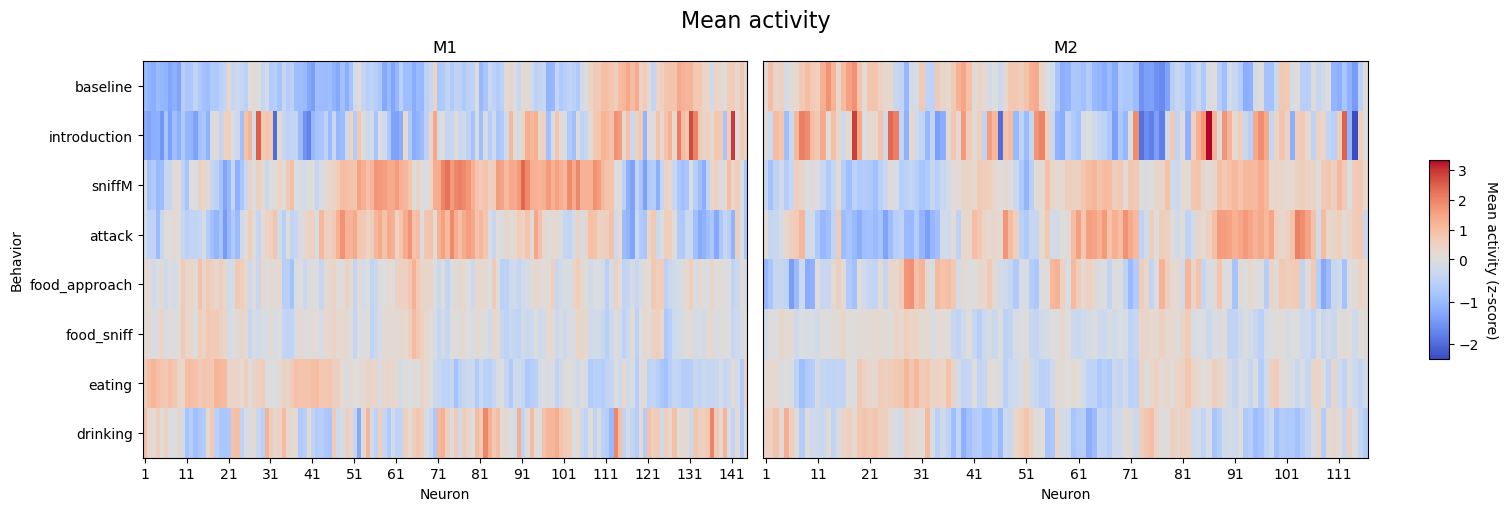

In [8]:
# Plot mean activity
fig, axs = plt.subplots(ncols = 2, figsize=(15, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = min(mean_activity_M1.min(), mean_activity_M2.min())
vmax = max(mean_activity_M1.max(), mean_activity_M2.max())
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im0 = axs[0].imshow(mean_activity_M1, cmap='coolwarm', aspect='auto', norm=divnorm)
axs[0].set_title('M1')
axs[0].set_xticks(np.arange(n_neurons_M1, step=10))
axs[0].set_xticklabels(np.arange(n_neurons_M1, step=10)+1)
axs[0].set_xlabel('Neuron')
axs[0].set_yticks(np.arange(n_labels))
axs[0].set_yticklabels(labels)
axs[0].set_ylabel('Behavior')

im1 = axs[1].imshow(mean_activity_M2, cmap='coolwarm', aspect='auto', norm=divnorm)
axs[1].set_title('M2')
axs[1].set_xticks(np.arange(n_neurons_M2, step=10))
axs[1].set_xticklabels(np.arange(n_neurons_M2, step=10)+1)
axs[1].set_xlabel('Neuron')
axs[1].set_yticks([])

# Add a colarbar
cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('Mean activity', fontsize=16)
plt.savefig("/Users/alveus/Downloads/figures_20231130/MeanActivity.svg")

## Cluster neurons

In [9]:
# Perform k-means with silhouette analysis
range_n_clusters = np.arange(2, n_labels+1) # Generate range of number of clusters to evaluate
fig, axs, n_clusters_M1 = plot_kmeans_silhouette(range_n_clusters, mean_activity_M1.T)
plt.close(fig)
fig, axs, n_clusters_M2 = plot_kmeans_silhouette(range_n_clusters, mean_activity_M2.T)
plt.close(fig)

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 the average silhouette_score is : 0.2635957793433824
For n_clusters = 3 the average silhouette_score is : 0.2694747045004175


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 4 the average silhouette_score is : 0.24719305481930912
For n_clusters = 5 the average silhouette_score is : 0.22988268146811652
For n_clusters = 6 the average silhouette_score is : 0.2192311410172594
For n_clusters = 7 the average silhouette_score is : 0.21417659819622145


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 the average silhouette_score is : 0.1921172662999608
The number of clusters that maximizes silhouette score is:  3
For n_clusters = 2 the average silhouette_score is : 0.23295447220181267
For n_clusters = 3 the average silhouette_score is : 0.2361281324992942


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 the average silhouette_score is : 0.2123832525752097
For n_clusters = 5 the average silhouette_score is : 0.1993297139229723
For n_clusters = 6 the average silhouette_score is : 0.19737234893343003
For n_clusters = 7 the average silhouette_score is : 0.21081151516664887
For n_clusters = 8 the average silhouette_score is : 0.21150520186708177
The number of clusters that maximizes silhouette score is:  3


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Generate raster plots

21
33
27
37
26
30
15
12
29
30


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 0.98, 'Tuning raster')

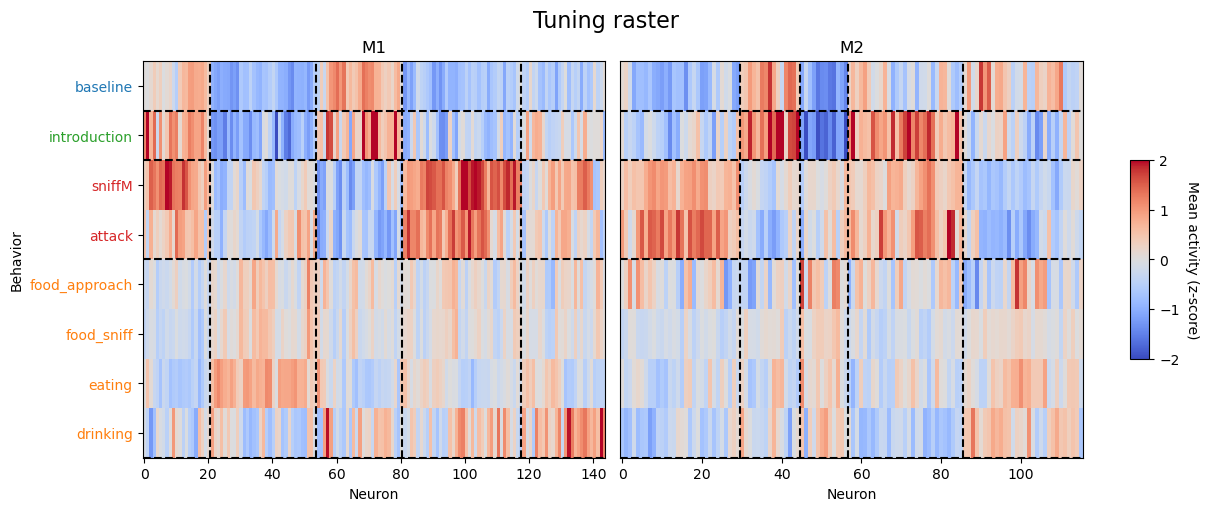

In [19]:
# Plot tuning raster
# Fit k-means clustering
n_clusters_M1 = 5
n_clusters_M2 = 5
cluster_labels_M1, data_reordered_M1, neuron_ids_reordered_M1 = fit_kmeans(n_clusters_M1, mean_activity_M1.T)
cluster_labels_M2, data_reordered_M2, neuron_ids_reordered_M2 = fit_kmeans(n_clusters_M2, mean_activity_M2.T)

# Plot tuning raster
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5), constrained_layout=True, gridspec_kw={'width_ratios': [n_clusters_M1, n_clusters_M2]})

# Determine the color scale based on the min and max of both datasets
vmin = min(mean_activity_M1.min(), mean_activity_M2.min())
vmax = max(mean_activity_M1.max(), mean_activity_M2.max())
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the first raster
# im0 = axs[0].imshow(data_reordered_M1.T, cmap='coolwarm', aspect='auto', norm=divnorm)
im0 = axs[0].imshow(data_reordered_M1.T, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
axs[0].set_title('M1')
# axs[0].set_xticks(np.arange(n_neurons_M1, step=10))
# axs[0].set_xticklabels(np.arange(n_neurons_M1, step=10)+1)
axs[0].set_xlabel('Neuron')
axs[0].set_yticks(np.arange(n_labels))
axs[0].set_yticklabels(labels)
axs[0].set_ylabel('Behavior')

# Separate clusters
for i in range(1, n_clusters_M1):
    axs[0].axvline(x=np.sum(cluster_labels_M1 < i) - 1/2, color='black', linestyle='--')

# Separate behaviors
group_indices = [1, 2, 4, 8] # Indices of the first behavior in each group
for b in group_indices:
    axs[0].axhline(y=b-1/2, color='black', linestyle='--')

# Plot the second raster
# im1 = axs[1].imshow(data_reordered_M2.T, cmap='coolwarm', aspect='auto', norm=divnorm)
im1 = axs[1].imshow(data_reordered_M2.T, cmap='coolwarm', aspect='auto', vmin=-2, vmax=2)
axs[1].set_title('M2')
# axs[1].set_xticks(np.arange(n_neurons_M2, step=10))
# axs[1].set_xticklabels(np.arange(n_neurons_M2, step=10)+1)
axs[1].set_xlabel('Neuron')
axs[1].set_yticks([])

# Color the yticklabels
ytickcolors = ['tab:blue',
                'tab:green',
                'tab:red', 'tab:red',
                'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange']

# Get the yticklabels and set their color
for i, yticklabel in enumerate(axs[0].get_yticklabels()):
    yticklabel.set_color(ytickcolors[i % len(ytickcolors)])

# Separate clusters
for i in range(1, n_clusters_M2):
    axs[1].axvline(x=np.sum(cluster_labels_M2 < i) - 1/2, color='black', linestyle='--')

# Separate behaviors
for b in group_indices:
    axs[1].axhline(y=b-1/2, color='black', linestyle='--')

# Add a colarbar
cbar = fig.colorbar(im0, ax=axs, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('Tuning raster', fontsize=16)
# plt.savefig("/Users/alveus/Downloads/figures_20231130/TuningRaster.svg")

In [15]:
cluster_labels_M1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4,
       2, 1, 4, 0, 4, 0, 4, 4, 4, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 3, 3, 3, 3, 3, 0, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       1, 1, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 2, 2, 4, 0, 2, 0, 2, 2], dtype=int32)

In [22]:
cluster_labels_M2

array([4, 4, 1, 1, 4, 4, 3, 3, 1, 1, 1, 1, 4, 1, 3, 4, 4, 1, 1, 4, 4, 4,
       4, 4, 1, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 1, 3, 0, 3, 0, 3,
       3, 2, 3, 3, 4, 4, 4, 4, 1, 1, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 0, 4, 4, 4, 2, 3, 3, 3, 3, 3, 0,
       3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 0, 4, 0, 0, 0,
       0, 3, 2, 2, 3, 4], dtype=int32)

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


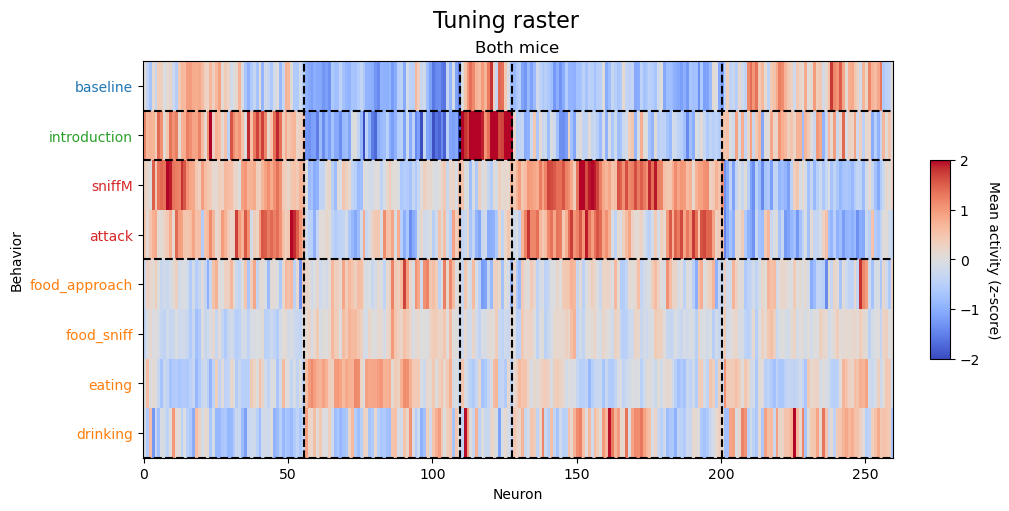

In [11]:
mean_activity_both = np.hstack([mean_activity_M1, mean_activity_M2])
n_neurons_both = mean_activity_both.shape[1]
n_clusters_both = 5
cluster_labels_both, data_reordered_both, neuron_ids_reordered_both = fit_kmeans(n_clusters_both, mean_activity_both.T)

# Plot tuning raster
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = mean_activity_both.min()
vmax = mean_activity_both.max()
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the tuning raster
im = ax.imshow(data_reordered_both.T, cmap='coolwarm', aspect='auto', interpolation='none', vmin=-2, vmax=2)
ax.set_title('Both mice')
# ax.set_xticks(np.arange(n_neurons_both, step=10))
# ax.set_xticklabels(np.arange(n_neurons_both, step=10)+1)
ax.set_xlabel('Neuron')
ax.set_yticks(np.arange(n_labels))
ax.set_yticklabels(labels)
ax.set_ylabel('Behavior')

# Get the yticklabels and set their color
for i, yticklabel in enumerate(ax.get_yticklabels()):
    yticklabel.set_color(ytickcolors[i % len(ytickcolors)])

# Separate clusters
for i in range(1, n_clusters_both):
    ax.axvline(x=np.sum(cluster_labels_both < i) - 1/2, color='black', linestyle='--')

# Separate behaviors
group_indices = [1, 2, 4, 8] # Indices of the first behavior in each group
for b in group_indices:
    ax.axhline(y=b-1/2, color='black', linestyle='--')

# Add a colarbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('Tuning raster', fontsize=16)
plt.savefig("/Users/alveus/Downloads/figures_20231130/TuningRasterBoth.svg")

## Make pie chart for male vs food populations

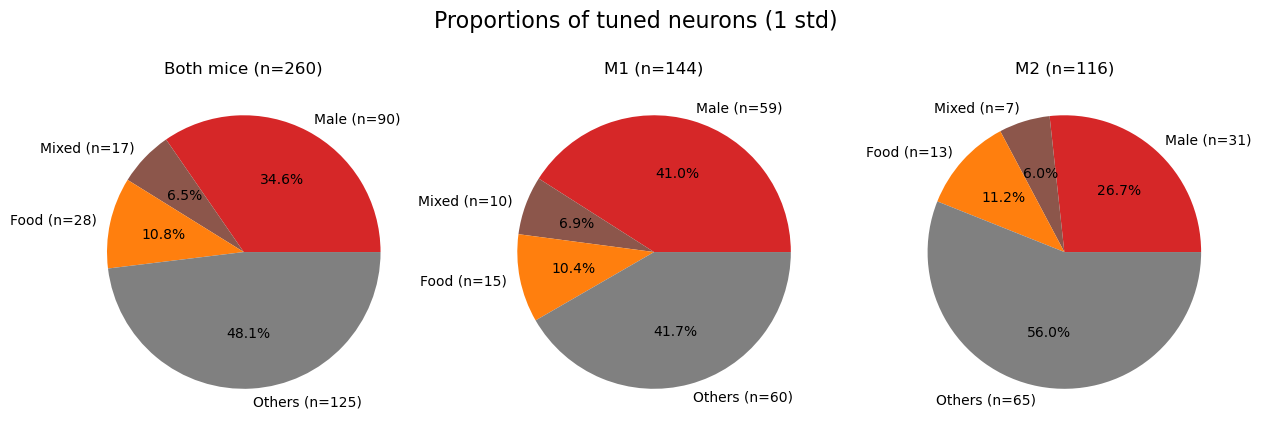

In [12]:
# Make pie charts for male and food responsive neurons
tuning_threshold = 1 # Threshold for determining whether a neuron is tuned to a behavior
# For both mice
male_responsive_both = np.any((mean_activity_both[2:4, :] > tuning_threshold) | (mean_activity_both[2:4, :] < -tuning_threshold), axis=0)
food_responsive_both = np.any((mean_activity_both[4:, :] > tuning_threshold) | (mean_activity_both[4:, :] < -tuning_threshold), axis=0)
mixed_responses_both = male_responsive_both & food_responsive_both
others_both = ~male_responsive_both & ~food_responsive_both
counts_both = [np.sum(male_responsive_both)-np.sum(mixed_responses_both), np.sum(mixed_responses_both), np.sum(food_responsive_both)-np.sum(mixed_responses_both), np.sum(others_both)]

# For M1
male_responsive_M1 = np.any((mean_activity_M1[2:4, :] > tuning_threshold) | (mean_activity_M1[2:4, :] < -tuning_threshold), axis=0)
food_responsive_M1 = np.any((mean_activity_M1[4:, :] > tuning_threshold) | (mean_activity_M1[4:, :] < -tuning_threshold), axis=0)
mixed_responses_M1 = male_responsive_M1 & food_responsive_M1
others_M1 = ~male_responsive_M1 & ~food_responsive_M1
counts_M1 = [np.sum(male_responsive_M1)-np.sum(mixed_responses_M1), np.sum(mixed_responses_M1), np.sum(food_responsive_M1)-np.sum(mixed_responses_M1), np.sum(others_M1)]

# For M2
male_responsive_M2 = np.any((mean_activity_M2[2:4, :] > tuning_threshold) | (mean_activity_M2[2:4, :] < -tuning_threshold), axis=0)
food_responsive_M2 = np.any((mean_activity_M2[4:, :] > tuning_threshold) | (mean_activity_M2[4:, :] < -tuning_threshold), axis=0)
mixed_responses_M2 = male_responsive_M2 & food_responsive_M2
others_M2 = ~male_responsive_M2 & ~food_responsive_M2
counts_M2 = [np.sum(male_responsive_M2)-np.sum(mixed_responses_M2), np.sum(mixed_responses_M2), np.sum(food_responsive_M2)-np.sum(mixed_responses_M2), np.sum(others_M2)]

# Create labels
pie_labels_both = [f'Male (n={counts_both[0]})', f'Mixed (n={counts_both[1]})', f'Food (n={counts_both[2]})', f'Others (n={counts_both[3]})']
pie_labels_M1 = [f'Male (n={counts_M1[0]})', f'Mixed (n={counts_M1[1]})', f'Food (n={counts_M1[2]})', f'Others (n={counts_M1[3]})']
pie_labels_M2 = [f'Male (n={counts_M2[0]})', f'Mixed (n={counts_M2[1]})', f'Food (n={counts_M2[2]})', f'Others (n={counts_M2[3]})']

pie_colors = ['tab:red', 'tab:brown', 'tab:orange', 'grey']

# Create a new figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the pie charts
axs[0].pie(counts_both, labels=pie_labels_both, autopct='%1.1f%%', colors=pie_colors)
axs[0].set_title(f'Both mice (n={n_neurons_both})')
axs[1].pie(counts_M1, labels=pie_labels_M1, autopct='%1.1f%%', colors=pie_colors)
axs[1].set_title(f'M1 (n={n_neurons_M1})')
axs[2].pie(counts_M2, labels=pie_labels_M2, autopct='%1.1f%%', colors=pie_colors)
axs[2].set_title(f'M2 (n={n_neurons_M2})')

plt.suptitle('Proportions of tuned neurons (1 std)', fontsize=16)
plt.savefig("/Users/alveus/Downloads/figures_20231130/TuningProportions.svg")